<a href="https://colab.research.google.com/github/juelha/IANNWTF/blob/main/hw5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Homework 05


In [ ]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import math

## 1 Dataset
Fashion MNIST Dataset.
This is a dataset of 60,000 28x28 grayscale images of 10 fashion categories, along with a test set of 10,000 images. 
https://keras.io/api/datasets/fashion_mnist/


In [ ]:
# load Fashion Dataset from Keras
(train_images, train_labels),(test_images, test_labels) = keras.datasets.fashion_mnist.load_data()

# normalise pixel values 
train_images = train_images /  255.0
test_images = test_images / 255.0
validation_images = train_images[:5000]
validation_labels = train_labels[:5000]

# assert that the number and size of the images/labels are as expected
assert train_images.shape == (60000, 28, 28)
assert test_images.shape == (10000, 28, 28)
assert train_labels.shape == (60000,)
assert test_labels.shape == (10000,)

# assign the correct labels to the respective images
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

def preprocessing(tensor):
  """ apply a preprocessing pipeline to the given dataset
  :param tensor: data to be preprocessed
  :return: preprocessed dataset
  """
  # map the labels to one_hot labels and expand the last dimension of the images 
  tensor = tensor.map(lambda images, labels: (tf.expand_dims(images, -1), tf.one_hot(labels, 10)))
  # cache this progress in memory
  tensor = tensor.cache()
  # shuffle, batch, prefetch
  tensor = tensor.shuffle(1000)
  tensor = tensor.batch(32)
  tensor = tensor.prefetch(20)
  # return preprocessed dataset
  return tensor


In [ ]:
# apply the preprocessing pipeline to both the training and the test dataset
train_dataset = train_dataset.apply(preprocessing)
test_dataset = test_dataset.apply(preprocessing)


## 2 Model

3 convolutional layers with a kernel size of 3, no stride and ’same’ padding, alternating with 2 pooling layers of size 2, finally a dense layer with 10 output neurons.

Convolutional layers use ReLU activation: selected because it's both simple to implement and less susceptible to vanishing gradients that prevent deep models from being trained

Final dense layer uses softmax, selected because it's good for multiclass classification tasks with one node for each class



In [ ]:
class MyModel(tf.keras.Model):
  """ This is a custom CNN Model"""
  def __init__(self):
    """Constructor function"""
    super(MyModel, self).__init__()
    self.conv1 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(28, 28))
    self.maxpooling1 = tf.keras.layers.MaxPooling2D((2, 2))
    self.conv2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')
    self.maxpooling2 = tf.keras.layers.MaxPooling2D((2, 2))
    self.conv3 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')
    #flatten layer with Global Max Pooling for the dense layer
    self.flatten = tf.keras.layers.GlobalMaxPooling2D()
    self.dense1 = tf.keras.layers.Dense(10, activation='softmax')
      
  @tf.function
  def call(self, inputs):
    """Build up the Model of alternating Conv2D layers and pooling layers
    and finally a Dense layer
    :param inputs: tensorflow dataset
    """
    x = self.conv1(inputs)
    x = self.maxpooling1(x)
    x = self.conv2(x)
    x = self.maxpooling2(x)
    x = self.conv3(x)
    x = self.flatten(x)
    x = self.dense1(x)
    return x
    

In [ ]:
def train_step(model, input, target, loss_function, optimizer):
  """Applys optimizer to all trainable variables of this model to
  minimize the loss (loss_function) between the target output and the
  predicted ouptut.
  :param input: tf.Tensor input to the model
  :param target: target output with repect to the input
  :return: the loss and the accuracy of the models prediction
   """
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss

def test(model, test_data, loss_function):
  """Calculate the mean loss and accuracy of the model over all elements
  of test_data.
  :param test_data: model is evaulated for test_data
  :param: loss_function: chosen cost function
  :return: mean loss and mean accuracy for all datapoints
  """

  # test over complete test data
  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input)
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = tf.reduce_mean(test_loss_aggregator)
  test_accuracy = tf.reduce_mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

## 3 Training 

Finally put everything together
- We trained our model with 10 epochs using a learning rate of 0.001.
- As a loss function we used the categorical cross entropy as it is used in 
multiclass classification to compute loss between true labels and predicted labels. 
- As an optimizer use Adam - which according to Kingma et al., 2014, the method is 
"computationally efficient, has little memory requirement, invariant to diagonal 
rescaling of gradients, and is well suited for problems that are large in terms 
of data/parameters"




In [ ]:
tf.keras.backend.clear_session()

### Hyperparameters
num_epochs = 10
learning_rate = 0.001

# Initialize the model.
model = MyModel()
# Initialize the loss.
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Initialize the optimizer.
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Initialize lists for later visualization.
train_losses = []
train_accuracies = []

test_losses = []
test_accuracies = []

#testing once before we begin
test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin
train_loss, train_accuracy = test(model, train_dataset, cross_entropy_loss)
train_losses.append(train_loss)
train_accuracies.append(train_accuracy)


# train for num_epochs epochs.
for epoch in range(num_epochs):
    print(f'Epoch: {str(epoch)} starting with accuracy {test_accuracies[-1]}')
    
    #training (and checking in with training)
    epoch_loss_agg = []
    for input,target in train_dataset:
        train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
        epoch_loss_agg.append(train_loss)
    
    #track training loss
    train_losses.append(tf.reduce_mean(epoch_loss_agg))

    #testing, so we can track accuracy and test loss
    test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    print(f'Train Losses: {train_loss}, Test Losses: {test_loss}')

Epoch: 0 starting with accuracy 0.09424920127795527
Train Losses: 0.2225833535194397, Test Losses: 0.41317319869995117
Epoch: 1 starting with accuracy 0.8451477635782748
Train Losses: 0.4708220362663269, Test Losses: 0.33092063665390015
Epoch: 2 starting with accuracy 0.8785942492012779
Train Losses: 0.26694849133491516, Test Losses: 0.3191797137260437
Epoch: 3 starting with accuracy 0.8893769968051118
Train Losses: 0.21095629036426544, Test Losses: 0.29848337173461914
Epoch: 4 starting with accuracy 0.893470447284345
Train Losses: 0.21926723420619965, Test Losses: 0.28576529026031494
Epoch: 5 starting with accuracy 0.8987619808306709
Train Losses: 0.10800175368785858, Test Losses: 0.3688660264015198
Epoch: 6 starting with accuracy 0.8809904153354633
Train Losses: 0.1930726170539856, Test Losses: 0.2693524956703186
Epoch: 7 starting with accuracy 0.909944089456869
Train Losses: 0.22294366359710693, Test Losses: 0.2529241144657135
Epoch: 8 starting with accuracy 0.9140375399361023
Train

##4 Visualization


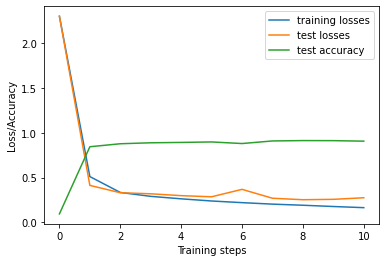

In [ ]:
# Visualize accuracy and loss for training and test data.

plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
line3, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Loss/Accuracy")
plt.legend((line1,line2, line3),("training losses","test losses", "test accuracy"))
plt.show()

## 5 Receptive Field Size


In [ ]:
# Algorithm to calculate the receptive field size of the architecture

conv_net = {
# [filter size, stride, padding]
    'conv1': [3,1,1],
    'pool1': [2,1,0],
    'conv2': [3,1,1],
    'pool2': [2,1,0],
    'conv3': [3,1,1],
    'dense1': [1,1,0]
}

class ReceptiveFieldCalculator():
    def calculate(self, architecture, input_image_size):
        input_layer = ('input_layer', input_image_size, 3, 1, 1.5)
        self._print_layer_info(input_layer)
        
        for key in architecture:
            current_layer = self._calculate_layer_info(architecture[key], input_layer, key)
            self._print_layer_info(current_layer)
            input_layer = current_layer
            
    def _print_layer_info(self, layer):
        print(f'------')
        print(f'{layer[0]}: n = {layer[1]}; r = {layer[2]}; j = {layer[3]}; start = {layer[4]}')     
        print(f'------')
            
    def _calculate_layer_info(self, current_layer, input_layer, layer_name):
        n_in = input_layer[1]
        j_in = input_layer[2]
        r_in = input_layer[3]
        start_in = input_layer[4]
        
        k = current_layer[0]
        s = current_layer[1]
        p = current_layer[2]

        n_out = math.floor((n_in - k + 2*p)/s) + 1
        padding = (n_out-1)*s - n_in + k 
        p_right = math.ceil(padding/2)
        p_left = math.floor(padding/2)

        j_out = j_in * s
        r_out = r_in + (k - 1)*j_in
        start_out = start_in + ((k-1)/2 - p_left)*j_in
        return layer_name, n_out, j_out, r_out, start_out

calculator = ReceptiveFieldCalculator()
calculator.calculate(conv_net, 28)

------
input_layer: n = 28; r = 3; j = 1; start = 1.5
------
------
conv1: n = 28; r = 3; j = 7; start = 1.5
------
------
pool1: n = 27; r = 3; j = 10; start = 3.0
------
------
conv2: n = 27; r = 3; j = 16; start = 3.0
------
------
pool2: n = 26; r = 3; j = 19; start = 4.5
------
------
conv3: n = 26; r = 3; j = 25; start = 4.5
------
------
dense1: n = 26; r = 3; j = 25; start = 4.5
------
